# Prediction of Bacterial Growth Rate and Yield from Full Genomic Data 

## Danesh Moradigaravand 
### Center for Computational Biology
### University of Birmingham 

***

Bacterial growth is known to be determined by ecological factors, inclduing antimicrobial resistance. High throughput growth assays allow rapid parallel screening for a large number of bacterial strains in a short period of time. I comnive this capability with the wealth of information from WGS of bacterial sequences to predict the bacterial sequences. 

Here I will present a full implementation of a data analytics pipeline, in which bacterial growth is treated as a continious trait and genomic features are used as predictors. Three predictive models will be exaimned:

**1. Base line regularized regression Model**

**2. Ensemble model based on gradient boosted regression trees**

**3. Residual Neural Network**

These choice of these models reflect the increasing the complexity and accounting for high order interaction amonsgt input features. As for the genetic input features, I have used the output of the pan-genome recontruction pipeline, Roary, and the and the output of the resistome from the ARIBA pipeline. The model employs the Scikit-learn and Keras libraries. 

The pipeline comprise of following steps:

**Input Reading and Feature engineering &rarr; Model Training &rarr; Inference &rarr; Prediction &rarr; Annotation and feature importance analysis**

---
## 1-Input Reading and Feature Engineering

### pan-genome file manipulation

The input of the algorithm is the CSV and R file output of Roary. In the first step, duplicated entries are removed.



In [21]:
class Processed():
    def __init__(self,PATH):
        self.PATH=PATH
        
    def deduplication(self, Rtab,Gene_PA):
        import os
        import pandas as pd
        tmp_tab=pd.DataFrame()
        Rtab=os.path.join(self.PATH, "gene_presence_absence.Rtab")
        Gene_PA=os.path.join(self.PATH, "gene_presence_absence.csv")
        
        if not os.path.isfile( Rtab):
            print("No Rtab file")
            return
        else:
            print("Reading Rtab file")
            tmp_tab= pd.read_csv( Rtab,index_col=0)
            print("Rtab file is imported")
            
        if not os.path.isfile(Gene_PA):
            print("No accessory gene file")
            return
        
        print("Reading Rtab file")
        
        print("Delete non-unique Genes activated")
        print("Accessory gene file")
        tmp_csv=pd.read_csv(Gene_PA, usecols = ["Gene","Non-unique Gene name"])
        id_un=np.where(tmp_csv["Non-unique Gene name"].isnull())[0]
        print("Number of genes before removing genes: %d" % tmp_tab.shape[0])
        tmp_tab=tmp_tab.iloc[id_un,:]
        print("Number of genes after removing genes: %d" % tmp_tab.shape[0])

        print("\nRemoving correlated gene clusters")
        print("Number of genes before clustering: %d" % tmp_tab.shape[0])
        tmp_dedup=tmp_tab.drop_duplicates()
        print("Number of genes after clustering: %d" % tmp_dedup.shape[0])
        Gene_inp=tmp_dedup.transpose()
        Gene_inp.to_csv(os.path.join(self.PATH, "processed_gene_presence_absence.Rtab"))

    def join_feature_response(self,features_file, response_file, column=0, dropNA=True):
        import os
        import pandas as pd
    
        features_dataframe=pd.read_csv(os.path.join(self.PATH, features_file), index_col=0, sep="\t")
        reponse_dataframe=pd.read_csv(os.path.join(self.PATH, response_file), index_col=0, sep="\t")
        
        print("Joining Trait:"+reponse_dataframe.columns[column])
        input_dataframe=reponse_dataframe[[reponse_dataframe.columns[column]]].join(features_dataframe,how='inner')
        input_dataframe=input_dataframe.dropna(axis=0, how='any', inplace=False)
        input_dataframe.columns.values[0]='label'
        return(input_dataframe)

    def split_train_test_save_output(self, input_dataset,postfix,label='label',save=False, test_size=0.2):
        import os
        import numpy as np
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split( input_dataset.drop(columns=['label']),input_dataset[['label']], test_size=test_size, random_state=1)
        if save:
            X_train.to_csv(os.path.join(self.PATH, 'X_train_'+postfix+'.txt'), sep="\t")
            X_test.to_csv(os.path.join(self.PATH, 'X_test_'+postfix+'.txt'), sep="\t")
            y_train.to_csv(os.path.join(self.PATH, 'y_train_'+postfix+'.txt'), sep="\t")
            y_test.to_csv(os.path.join(self.PATH, 'y_test_'+postfix+'.txt'), sep="\t")
        return(np.array(X_train), np.array(X_test), np.squeeze(np.array(y_train)), np.squeeze(np.array(y_test)))

#preparation dataset 
PATH="/Users/moradigd/Documents/Prediction/"

response='Metadata_median_NoAB.txt'
features='pangene.txt'

---
## 3-Model design

We employ three classes of predictive models. The baseline lasso regression, the gradient boosted regression models and residual neural networks.  


## Gradient boosted regression tree

In order to opmtimize the parameters, we first create a set of grid search parameters for the gradient boosted regression model. In the next step the model will be tuned with 2-fold cross validation. Best parameters and predictions are stored.  

In [1]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
import numpy as np
import pandas as pd

params={
    'n_estimators':[100,200],
    'max_depth':[2, 4],
    'min_samples_split':[2],
    'learning_rate':[0.01],
    'loss':['ls']
}

def param_gridsearch_xgregressor(PATH, *params):
    '''
    input: PATH
    dictionary of parameter values for gradient boosting trees
    output: parameter file
    '''

    output_param=[]
    import os
    import pandas as pd
    for i in params[0]['n_estimators']:
        for j in params[0]['max_depth']:
            for k in params[0]['min_samples_split']:
                for b in params[0]['learning_rate']:
                    for m in params[0]['loss']:
                        output_param.append([i,j,k,b,m])
    df=pd.DataFrame(output_param, columns=['n_estimators','max_depth','min_samples_split','learning_rate','loss'])
    df.to_csv(os.path.join(PATH, 'xgregressor_param.txt'), sep="\t")
    return(df)

def predictor_boostingregressor(X_train_val,y_train_val, X_test,y_test,params_matrix):
    mse_grid=[]
    for i in range(params_matrix.shape[0]):
        print(i/params_matrix.shape[0])
        params=params_matrix.iloc[i,:].to_dict()
        print(params)    
        rf=ensemble.GradientBoostingRegressor(**params)
        scores = cross_validate(rf, X_train_val,y_train_val, scoring=['neg_mean_squared_error'], cv=2)
        mse_grid.append(np.mean(scores['test_neg_mean_squared_error'])) 
        print(np.mean(scores['test_neg_mean_squared_error']))
    
    best_params=params_matrix.iloc[np.argmin(mse_grid),:].to_dict()
    model = ensemble.GradientBoostingRegressor(**best_params)
    model.fit(X_train_val,y_train_val) 
    #mse = mean_squared_error(y_test, model.predict(X_test))
    return(best_params, model)


PATH='/Users/moradigd/Documents/Prediction/Pan_genome'
params_matrix_regressor=param_gridsearch_xgregressor(PATH, params)
params_matrix_regressor

,n_estimators,max_depth,min_samples_split,learning_rate,loss
0,100,2,2,0.01,ls
1,100,4,2,0.01,ls
2,200,2,2,0.01,ls
3,200,4,2,0.01,ls


## Lasso 

In order to opmtimize the parameters, we first create a set of grid search parameters for the gradient boosted regression model. 

In [43]:
param_gridsearch_lasso(PATH, params)

,alpha
0,1.000000e-15
1,1.000000e-10
2,1.000000e-08
3,1.000000e-05
4,1.000000e-04
5,1.000000e-03
6,1.000000e-02
7,1.000000e+00
8,5.000000e+00
9,1.000000e+01


In [2]:
params={'alpha':[1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]}
def param_gridsearch_lasso(PATH, *params):
    '''
    input: PATH
    dictionary of parameter values for lasso
    output: parameter file
    '''
    import os
    import pandas as pd
    output_param=[]
    for i in params[0]['alpha']:
        output_param.append(i)
    df=pd.DataFrame(output_param, columns=['alpha'])
    df.to_csv(os.path.join(PATH, 'lasso_param.txt'), sep="\t")
    return(df)

PATH='/Users/moradigd/Documents/Prediction/Pan_genome'
params_matrix_lasso=param_gridsearch_lasso(PATH, params)

def predictor_lasso(X_train_val,y_train_val, X_test,y_test,params_matrix):
    from sklearn.linear_model import Lasso
    mse_grid=[]
    for i in range(params_matrix.shape[0]):
        print(i/params_matrix.shape[0])
        params=params_matrix.iloc[i,:].to_dict()
        print(params)
        lassoreg = Lasso(normalize=True, max_iter=1e5, **params)
        scores = cross_validate(lassoreg, X_train_val,y_train_val, scoring=['neg_mean_squared_error'], cv=2)
        mse_grid.append(np.mean(scores['test_neg_mean_squared_error']))
    
    best_params=params_matrix.iloc[np.argmin(mse_grid),:].to_dict()
    model = Lasso(normalize=True, max_iter=1e5, **best_params)
    model.fit(X_train_val,y_train_val) 
    return(best_params, model)

## Residual Neural Networks

In order to opmtimize the parameters, we first create a set of grid search parameters for the gradient boosted regression model. 

In [58]:
params={
    'layer_number':[2,3,4],
    'node_number':[20,30,60],
    'resnet':[True, False]
}

L2_WEIGHT_DECAY=0.02
BATCH_NORM_DECAY=0.999
BATCH_NORM_EPSILON=0.0001
params

{'layer_number': [2, 3, 4],
 'node_number': [20, 30, 60],
 'resnet': [True, False]}

In [59]:
def param_gridsearch_resnetdense(PATH, *params):
    output_param=[]
    import os
    for i in params[0]['layer_number']:
        for j in params[0]['node_number']:
            for k in params[0]['resnet']:
                output_param.append([i,j,k])
    df=pd.DataFrame(output_param, columns=['layer_number','node_number','resnet'])
    df.to_csv(os.path.join(PATH, 'resnetdense_param.txt'), sep="\t")
    return(df)

params_matrix_resnetdense=param_gridsearch_resnetdense(PATH, params)

In [3]:
from keras import layers
from keras import regularizers
from keras import models

L2_WEIGHT_DECAY=0.02
BATCH_NORM_DECAY=0.999
BATCH_NORM_EPSILON=0.0001

params={
    'layer_number':[2,4,6],
    'node_number':[20,30,60],
    'dropout':[0,0.2]
    'resnet':[True, False]
}

#layer_number=[2,4,6]
#node_number=[20,30,60]
#dropout=[0,0.2]
#resnet=[True, False]

def param_gridsearch_resnetdense(PATH, *params):
    output_param=[]
    import os
    for i in params[0]['layer_number']:
        for j in params[0]['node_number']:
            for k in params[0]['resnet']:
                for m in params[0]['dropout']:
                    output_param.append([i,j,k,m])
    df=pd.DataFrame(output_param, columns=['layer_number','node_number','resnet', 'dropout'])
    df.to_csv(os.path.join(PATH, 'resnetdense_param.txt'), sep="\t")
    return(df)

params_matrix_resnetdense=param_gridsearch_resnetdense(PATH,params)

def identity_block_resnet(input_shape, layer_number, node_number, dropout, resnet=True):
    input_tensor = layers.Input(shape=[ input_shape[1], ])    
    x = layers.Dense(node_number,input_dim=input_shape[1], use_bias=False, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(input_tensor)
    x = layers.BatchNormalization(axis=-1, momentum=BATCH_NORM_DECAY, epsilon=BATCH_NORM_EPSILON)(x)
    x = layers.Activation('relu')(x)
    
    for j in range(layer_number):
        x = layers.Dropout( dropout)(x)
        x = layers.Dense(node_number, use_bias=False, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(x)
        x = layers.BatchNormalization(axis=-1, momentum=BATCH_NORM_DECAY, epsilon=BATCH_NORM_EPSILON)(x)
        x = layers.Activation('relu')(x)
    
    x = layers.Dense(input_shape[1], use_bias=False, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(x)
    x = layers.BatchNormalization(axis=-1, momentum=BATCH_NORM_DECAY, epsilon=BATCH_NORM_EPSILON)(x)
    x = layers.Activation('relu')(x)
    
    if resnet:
        x = layers.add([x, input_tensor])
    x = layers.Dense(1, use_bias=False, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(x)

    return models.Model(input_tensor, x, name='ResNet Sequential')


def predictor_resnet(X_train_val,y_train_val, X_test,y_test,params_matrix):
    mse_grid=[]
    for i in range(params_matrix.shape[0]):
        print(i/params_matrix.shape[0])
        params=params_matrix.iloc[i,:].to_dict()
        print(params)
    
        model=identity_block_resnet(X_train_val.shape, **params)
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
        model.fit(X_train_val, y_train_val, epochs = 5, batch_size = 32, validation_split=0.2)
    
        mse = mean_squared_error(y_test, np.squeeze(model.predict(X_test)))
        mse_grid.append(mse)

    best_params=params_matrix.iloc[np.argmin(mse_grid),:].to_dict()
    model=identity_block_resnet(X_train_val.shape, **best_params)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    model.fit(X_train_val, y_train_val, epochs = 5, batch_size = 32, validation_split=0.2)
    return(best_params, model)

Using TensorFlow backend.


## Report and Results storage

In order to opmtimize the parameters, we first create a set of grid search parameters for the gradient boosted regression model. 

In [4]:
def store_best_param(PATH, postfix,model_type, best_params):
    if model_type=='xgr':
        df=pd.DataFrame(best_params, columns=['n_estimators','max_depth','min_samples_split','learning_rate','loss'], index=['xgr'])
        df.to_csv(os.path.join(PATH, 'best_params_gbregressor_'+postfix+'_'+model_type+'.txt'), sep="\t")
    elif model_type=='lasso':
        df=pd.DataFrame(best_params, columns=['alpha'], index=['lasso'])
        df.to_csv(os.path.join(PATH, 'best_params_lasso_'+postfix+'_'+model_type+'.txt'), sep="\t")    
    elif model_type=='resnet':
        df=pd.DataFrame(best_params, columns=['layer_number','node_number','resnet', 'dropout'], index=['resnet'])
        df.to_csv(os.path.join(PATH, 'best_params_resnet_'+postfix+'_'+model_type+'.txt'), sep="\t")
        
        
def store_prediction(model,y_test, X_test,model_type, PATH, postfix):
    df=pd.DataFrame(list(zip(np.squeeze(y_test),np.squeeze(model.predict(X_test)))), columns=['test','predicted'])
    df.to_csv(os.path.join(PATH, 'prediction_'+model_type+'_'+postfix+'_'+model_type+'.txt'), sep="\t")



## Run Models

In order to opmtimize the parameters, we first create a set of grid search parameters for the gradient boosted regression model. 

In [5]:
import pandas as pd
PATH="/Users/moradigd/Documents/Prediction/"

response='Metadata_median_NoAB.txt'
features='pangene.txt'
response_dataframe=pd.read_csv(os.path.join(PATH, response), index_col=0, sep="\t")
response_dataframe

,r_NoAB,y_NoAB,r_CAM-0.5,y_CAM-0.5,r_CAM-1,y_CAM-1,r_CAM-2,y_CAM-2,r_CIP-0.002,y_CIP-0.002,...,r_TET-0.6,y_TET-0.6,r_TET-1.25,y_TET-1.25,r_TRIM-0.125,y_TRIM-0.125,r_TRIM-0.25,y_TRIM-0.25,r_TRIM-0.5,y_TRIM-0.5
Lane,,,,,,,,,,,,,,,,,,,,,
24742_1#1,NaN,NaN,-0.555188,-0.894984,-0.537717,-1.107236,-0.824196,-0.894818,-0.637241,-1.241845,...,-0.166475,0.494444,-0.359683,-0.122013,0.084034,-1.859038,-0.704300,-3.234576,-0.492798,-1.187767
24742_1#2,0.104275,-0.623624,-0.171375,-0.341843,-0.124909,0.206825,-0.830909,1.894838,-0.006351,0.484449,...,-0.767449,3.515031,-1.562286,5.739422,-0.318986,0.495341,-0.339357,1.228346,-0.340873,3.262149
24742_1#3,-0.081769,-0.301323,-0.119350,0.078526,-0.127551,0.168754,-0.418040,0.443903,-0.290227,0.744871,...,-0.697390,3.488927,-1.532580,5.351141,-0.256452,0.771651,-0.497930,1.476964,-0.483559,3.626248
24742_1#4,-0.084430,-0.849137,-0.205950,-0.673437,-0.148708,-0.645597,-0.486796,-0.152780,-0.087412,-0.114168,...,-0.665094,2.380797,-1.246116,1.119005,-0.318859,-0.186104,-0.402424,1.191143,-0.555719,2.990016
24742_1#5,-0.243146,-0.591028,-0.183318,-0.762312,-0.206379,-0.601047,-0.750989,0.362407,-0.404123,0.457321,...,-1.192005,3.974147,-2.211937,5.633334,-0.520739,-0.236159,-0.576419,1.004208,-0.731796,2.807436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27970_2#376,-0.255959,-0.918329,-0.433526,-0.624229,-0.567971,-0.249068,-0.799909,0.549171,0.008598,0.327217,...,-0.520976,2.521096,-0.725536,3.014558,-0.269622,-1.172193,-0.396228,-0.768612,-0.273833,0.853602
27970_2#377,0.297314,-1.094470,0.143121,-0.941989,0.104264,-0.337694,-0.453345,1.043838,-0.218012,-0.341449,...,-0.611401,3.973458,-1.577047,6.072258,-0.244862,-1.025116,-0.178759,-0.494948,-0.097135,0.408245
27970_2#378,-0.626151,0.903940,-0.339344,1.155166,-0.700835,1.268132,-0.568980,2.634798,-0.073093,1.537021,...,-1.132368,5.478577,-1.833554,6.889389,0.529120,-2.920050,0.523254,-3.453022,0.518535,-2.495402


In [53]:
params_matrix_resnetdense

NameError: name 'params_matrix_resnetdense' is not defined

In [7]:
import pandas as pd
PATH="/Users/moradigd/Documents/Prediction/"

response='Metadata_median_NoAB.txt'
features='pangene.txt'
response_dataframe=pd.read_csv(os.path.join(PATH, response), index_col=0, sep="\t")

from sklearn.metrics import mean_squared_error
#for j in range(10,response_dataframe.shape[1]):
for j in range(0,1):
    print(j)
    #input_dataset=join_feature_response(features, response,PATH, i)

    X_train=pd.read_csv(os.path.join(PATH, 'X_train_'+response_dataframe.columns[j]+'.txt'), sep="\t", index_col=0)
    X_test=pd.read_csv(os.path.join(PATH, 'X_test_'+response_dataframe.columns[j]+'.txt'), sep="\t", index_col=0)

    y_train=pd.read_csv(os.path.join(PATH, 'y_train_'+response_dataframe.columns[j]+'.txt'), sep="\t", index_col=0)
    y_test=pd.read_csv(os.path.join(PATH, 'y_test_'+response_dataframe.columns[j]+'.txt'), sep="\t", index_col=0)

    X_train=X_train.to_numpy()
    X_test=X_test.to_numpy()
    y_train=y_train.to_numpy()
    y_test=y_test.to_numpy()
    
    best_params, model = predictor_boostingregressor(X_train,y_train, X_test,y_test,params_matrix_regressor)
    
    store_best_param(PATH, response_dataframe.columns[j], 'xgr', best_params)
    store_prediction(model,y_test, X_test,'xgr', PATH,response_dataframe.columns[j])
    
    best_params, model = predictor_lasso(X_train,y_train, X_test,y_test,params_matrix_lasso)    

    store_best_param(PATH, response_dataframe.columns[j], 'lasso', best_params)
    store_prediction(model,y_test, X_test,'lasso', PATH,response_dataframe.columns[j])
    
    #best_params, model = predictor_cnn(X_train,y_train, X_test,y_test,params_matrix_resnetcnn)    

    #store_best_param(PATH, response_dataframe.columns[j], 'cnn', best_params)
    #store_prediction(model,y_test, np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1)),'cnn', PATH,response_dataframe.columns[j])
    
    best_params, model = predictor_resnet(X_train,y_train, X_test,y_test,params_matrix_resnetdense)
    
    store_best_param(PATH, response_dataframe.columns[j], 'resnet', best_params)
    store_prediction(model,y_test, X_test,'resnet', PATH,response_dataframe.columns[j])
    
    

0
0.0
{'n_estimators': 100, 'max_depth': 2, 'min_samples_split': 2, 'learning_rate': 0.01, 'loss': 'ls'}


/Users/moradigd/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moradigd/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-0.11938018144365509
0.25
{'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2, 'learning_rate': 0.01, 'loss': 'ls'}


/Users/moradigd/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moradigd/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-0.11666819223364616
0.5
{'n_estimators': 200, 'max_depth': 2, 'min_samples_split': 2, 'learning_rate': 0.01, 'loss': 'ls'}


/Users/moradigd/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moradigd/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-0.11625315086643087
0.75
{'n_estimators': 200, 'max_depth': 4, 'min_samples_split': 2, 'learning_rate': 0.01, 'loss': 'ls'}


/Users/moradigd/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moradigd/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-0.11397912188993914


/Users/moradigd/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0
{'alpha': 1e-15}
0.1
{'alpha': 1e-10}
0.2
{'alpha': 1e-08}
0.3
{'alpha': 1e-05}
0.4
{'alpha': 0.0001}
0.5
{'alpha': 0.001}
0.6
{'alpha': 0.01}
0.7
{'alpha': 1.0}
0.8
{'alpha': 5.0}
0.9
{'alpha': 10.0}
0.0
{'layer_number': 2, 'node_number': 20, 'resnet': True, 'dropout': 0.0}
Train on 1024 samples, validate on 257 samples
Epoch 1/5
1024/1024 [==============================] - 40s 39ms/step - loss: 1396.0017 - mean_absolute_error: 2.9868 - val_loss: 1272.7371 - val_mean_absolute_error: 1.9556
Epoch 2/5
1024/1024 [==============================] - 3s 3ms/step - loss: 1170.9353 - mean_absolute_error: 0.9061 - val_loss: 1070.7772 - val_mean_absolute_error: 1.0039
Epoch 3/5
1024/1024 [==============================] - 3s 3ms/step - loss: 983.9585 - mean_absolute_error: 0.5003 - val_loss: 896.8139 - val_mean_absolute_error: 0.4590
Epoch 4/5
1024/1024 [==============================] - 3s 3ms/step - loss: 823.2044 - mean_absolute_error: 0.4823 - val_loss: 748.6822 - val_mean_absolute_error

1024/1024 [==============================] - 35s 35ms/step - loss: 1336.3226 - mean_absolute_error: 3.5755 - val_loss: 1136.8003 - val_mean_absolute_error: 1.7464
Epoch 2/5
1024/1024 [==============================] - 4s 4ms/step - loss: 984.2697 - mean_absolute_error: 0.8641 - val_loss: 837.1122 - val_mean_absolute_error: 0.7563
Epoch 3/5
1024/1024 [==============================] - 4s 4ms/step - loss: 721.8278 - mean_absolute_error: 0.4639 - val_loss: 610.8508 - val_mean_absolute_error: 0.5537
Epoch 4/5
1024/1024 [==============================] - 5s 5ms/step - loss: 525.5295 - mean_absolute_error: 0.5598 - val_loss: 443.7167 - val_mean_absolute_error: 0.7316
Epoch 5/5
1024/1024 [==============================] - 4s 4ms/step - loss: 381.2236 - mean_absolute_error: 0.6672 - val_loss: 321.7391 - val_mean_absolute_error: 0.8590
0.25
{'layer_number': 2, 'node_number': 60, 'resnet': True, 'dropout': 0.2}
Train on 1024 samples, validate on 257 samples
Epoch 1/5
1024/1024 [=================

Epoch 3/5
1024/1024 [==============================] - 3s 3ms/step - loss: 892.4627 - mean_absolute_error: 0.4597 - val_loss: 795.4957 - val_mean_absolute_error: 0.3697
Epoch 4/5
1024/1024 [==============================] - 3s 3ms/step - loss: 715.7085 - mean_absolute_error: 0.3850 - val_loss: 636.2660 - val_mean_absolute_error: 0.3636
Epoch 5/5
1024/1024 [==============================] - 3s 3ms/step - loss: 571.3855 - mean_absolute_error: 0.4060 - val_loss: 506.8410 - val_mean_absolute_error: 0.3182
0.4722222222222222
{'layer_number': 4, 'node_number': 30, 'resnet': True, 'dropout': 0.2}
Train on 1024 samples, validate on 257 samples
Epoch 1/5
1024/1024 [==============================] - 33s 33ms/step - loss: 1426.2345 - mean_absolute_error: 5.9906 - val_loss: 1239.0638 - val_mean_absolute_error: 2.2281
Epoch 2/5
1024/1024 [==============================] - 3s 3ms/step - loss: 1123.5113 - mean_absolute_error: 1.2422 - val_loss: 1006.5647 - val_mean_absolute_error: 0.5329
Epoch 3/5
10

Epoch 5/5
1024/1024 [==============================] - 3s 3ms/step - loss: 675.8108 - mean_absolute_error: 0.3831 - val_loss: 613.0959 - val_mean_absolute_error: 0.3451
0.6944444444444444
{'layer_number': 6, 'node_number': 20, 'resnet': True, 'dropout': 0.2}
Train on 1024 samples, validate on 257 samples
Epoch 1/5
1024/1024 [==============================] - 32s 31ms/step - loss: 1433.4595 - mean_absolute_error: 5.6571 - val_loss: 1266.3481 - val_mean_absolute_error: 2.2000
Epoch 2/5
1024/1024 [==============================] - 3s 3ms/step - loss: 1164.5039 - mean_absolute_error: 1.2485 - val_loss: 1060.2932 - val_mean_absolute_error: 0.3717
Epoch 3/5
1024/1024 [==============================] - 3s 3ms/step - loss: 973.5135 - mean_absolute_error: 0.4344 - val_loss: 885.6188 - val_mean_absolute_error: 0.4339
Epoch 4/5
1024/1024 [==============================] - 3s 3ms/step - loss: 811.4222 - mean_absolute_error: 0.4010 - val_loss: 736.6744 - val_mean_absolute_error: 0.3391
Epoch 5/5
10

1024/1024 [==============================] - 44s 43ms/step - loss: 1397.7159 - mean_absolute_error: 6.0405 - val_loss: 1175.7945 - val_mean_absolute_error: 2.0458
Epoch 2/5
1024/1024 [==============================] - 5s 5ms/step - loss: 1035.0937 - mean_absolute_error: 1.3090 - val_loss: 893.3210 - val_mean_absolute_error: 0.3363
Epoch 3/5
1024/1024 [==============================] - 4s 4ms/step - loss: 780.7416 - mean_absolute_error: 0.4907 - val_loss: 669.8517 - val_mean_absolute_error: 0.3474
Epoch 4/5
1024/1024 [==============================] - 4s 4ms/step - loss: 582.5641 - mean_absolute_error: 0.4732 - val_loss: 497.3742 - val_mean_absolute_error: 0.3960
Epoch 5/5
1024/1024 [==============================] - 4s 4ms/step - loss: 431.1512 - mean_absolute_error: 0.4893 - val_loss: 366.6976 - val_mean_absolute_error: 0.3253
0.9444444444444444
{'layer_number': 6, 'node_number': 60, 'resnet': False, 'dropout': 0.0}
Train on 1024 samples, validate on 257 samples
Epoch 1/5
1024/1024 [=

In [63]:
params_matrix_resnetdense

,layer_number,node_number,resnet
0,2,20,True
1,2,20,False
2,2,30,True
3,2,30,False
4,2,60,True
5,2,60,False
6,3,20,True
7,3,20,False
8,3,30,True
9,3,30,False


In [ ]:
best_params, model = predictor_resnet(X_train,y_train, X_test,y_test,params_matrix_resnetdense)
store_best_param(PATH, response_dataframe.columns[j], 'resnet', best_params)
store_prediction(model,y_test, X_test,'resnet', PATH,response_dataframe.columns[j])



0.0
{'layer_number': 2, 'node_number': 20, 'resnet': True, 'dropout': 0.0}
Instructions for updating:
Use tf.cast instead.
Train on 1024 samples, validate on 257 samples
Epoch 1/5
1024/1024 [==============================] - 5s 5ms/step - loss: 1436.3395 - mean_absolute_error: 5.4887 - val_loss: 1320.8926 - val_mean_absolute_error: 6.2644
Epoch 2/5
1024/1024 [==============================] - 3s 3ms/step - loss: 1176.1628 - mean_absolute_error: 1.1920 - val_loss: 1075.4602 - val_mean_absolute_error: 0.8740
Epoch 3/5
1024/1024 [==============================] - 3s 3ms/step - loss: 989.4612 - mean_absolute_error: 0.5396 - val_loss: 902.4669 - val_mean_absolute_error: 0.3811
Epoch 4/5
1024/1024 [==============================] - 2s 2ms/step - loss: 828.8850 - mean_absolute_error: 0.3682 - val_loss: 754.5133 - val_mean_absolute_error: 0.3596
Epoch 5/5
1024/1024 [==============================] - 2s 2ms/step - loss: 691.8752 - mean_absolute_error: 0.3571 - val_loss: 628.7202 - val_mean_abso

In [26]:
from skopt import BayesSearchCV
from skopt.callbacks import CheckpointSaver
checkpoint_saver = CheckpointSaver("/Users/moradigd/Documents/Prediction/checkpoint.pkl", compress=9)
opt = BayesSearchCV( SVC(), { 'C': Real(1e-6, 1e+6, prior='log-uniform'), 'gamma': Real(1e-6, 1e+1, prior='log-uniform'), 'degree': Integer(1,8), 'kernel': Categorical(['linear', 'poly', 'rbf']), }, n_iter=32 )

opt.fit(X_train, y_train,callback=[checkpoint_saver])

,n_estimators,max_depth,min_samples_split,learning_rate,loss
0,100,2,2,0.01,ls
1,100,4,2,0.01,ls
2,200,2,2,0.01,ls
3,200,4,2,0.01,ls


## SHAP

In order to opmtimize the parameters, we first create a set of grid search parameters for the gradient boosted regression model. 

In [71]:
import os
import shap
def exaplain_shap(model,X,y):
    model.fit(X,y)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    return(shap_values)

def save_model(model,PATH, tag):
    from pickle import dump
    dump(model, open(os.path.join(PATH, 'tuned_xgr_model_'+tag+'.txt'), 'wb'))

def load_model(PATH, tag): 
    from pickle import load
    return(load(open(os.path.join(PATH, 'tuned_xgr_model_'+tag+'.txt'), 'rb')))

PATH="/Users/moradigd/Documents/Prediction/"

response='Metadata_median_NoAB.txt'
features='pangene.txt'
response_dataframe=pd.read_csv(os.path.join(PATH, response), index_col=0, sep="\t")
response_dataframe.columns[0]

'r_NoAB'

In [95]:
from sklearn import ensemble
j=1
best_params=pd.read_csv(os.path.join(PATH, "best_params_gbregressor_"+response_dataframe.columns[j]+"_xgr.txt"), index_col=0, sep="\t")
best_model=ensemble.GradientBoostingRegressor(**best_params.to_dict('records')[0])

X_test=pd.read_csv(os.path.join(PATH, 'X_test_'+response_dataframe.columns[j]+'.txt'), sep="\t", index_col=0)
y_test=pd.read_csv(os.path.join(PATH, 'y_test_'+response_dataframe.columns[j]+'.txt'), sep="\t", index_col=0)

X_train=pd.read_csv(os.path.join(PATH, 'X_train_'+response_dataframe.columns[j]+'.txt'), sep="\t", index_col=0)
y_train=pd.read_csv(os.path.join(PATH, 'y_train_'+response_dataframe.columns[j]+'.txt'), sep="\t", index_col=0)

best_model.fit(X_train,np.ravel(y_train))

save_model(best_model,PATH, response_dataframe.columns[j])
shap_results=exaplain_shap(load_model(PATH, response_dataframe.columns[j]),X_test,y_test)

shap_max=pd.DataFrame(shap_results, columns=X_test.columns.values).max()
shap_max=shap_max[shap_max != 0].sort_values(na_position='first')
shap_max.index.name='Gene'
shap_max = shap_max.reset_index(name='SHAP')
shap_max.to_csv(os.path.join(PATH, 'new_shap_'+response_dataframe.columns[j]+'.txt'))

/Users/moradigd/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/moradigd/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


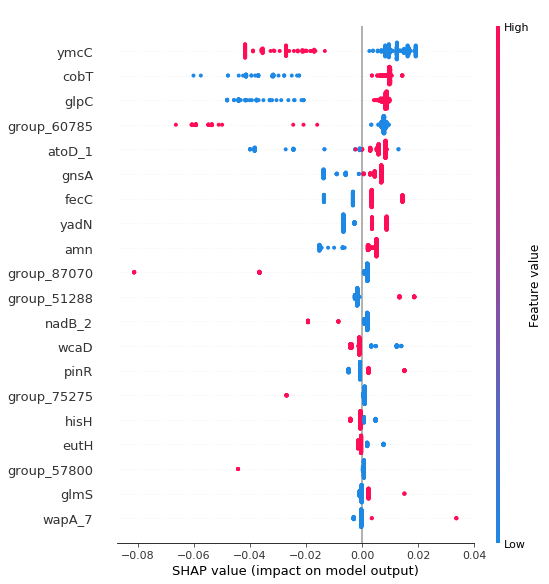

'r_NoAB'

In [96]:
shap.summary_plot(shap_results, X_test)
response_dataframe.columns[0]

## Gradient Boosted Decision Trees importance metrics

In order to opmtimize the parameters, we first create a set of grid search parameters for the gradient boosted regression model. 

In [120]:
j=0
best_params=pd.read_csv(os.path.join(PATH, "best_params_gbregressor_"+response_dataframe.columns[j]+"_xgr.txt"), index_col=0, sep="\t")
best_model=ensemble.GradientBoostingRegressor(**best_params.to_dict('records')[0])

X_test=pd.read_csv(os.path.join(PATH, 'X_test_'+response_dataframe.columns[j]+'.txt'), sep="\t", index_col=0)
y_test=pd.read_csv(os.path.join(PATH, 'y_test_'+response_dataframe.columns[j]+'.txt'), sep="\t", index_col=0)

X_train=pd.read_csv(os.path.join(PATH, 'X_train_'+response_dataframe.columns[j]+'.txt'), sep="\t", index_col=0)
y_train=pd.read_csv(os.path.join(PATH, 'y_train_'+response_dataframe.columns[j]+'.txt'), sep="\t", index_col=0)

best_model.fit(X_train,y_train)
save_model(best_model,PATH, response_dataframe.columns[j])

/Users/moradigd/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [121]:
def feature_gbr_importance(X_test,y_test, feature_name, iteration,PATH):
    output_feature_importance_agg=pd.DataFrame()
    for i in range(iteration):
        print(i/iteration)
        feature_names=np.array(X_test.columns.values)
        #model = load_model(PATH, response_dataframe.columns[0])
        model = load_model(PATH, feature_name)
        model.fit(X_test,np.ravel(y_test))
        importance=model.feature_importances_
    
        output_feature_importance=pd.DataFrame({'Gene':feature_names,'Importance':importance})
        output_feature_importance=output_feature_importance[output_feature_importance.Importance>0].sort_values(by=['Importance'], ascending=False)
        output_feature_importance['rank']=np.arange(output_feature_importance.shape[0])+1
        output_feature_importance_agg=output_feature_importance_agg.append(output_feature_importance, ignore_index = True)

    counts = output_feature_importance_agg.Gene.value_counts().to_dict()
    output_feature_importance_agg=output_feature_importance_agg.groupby(['Gene']).mean()
    output_feature_importance_agg['frequency']=[counts[i] for i in output_feature_importance_agg.index.tolist()]
    return(output_feature_importance_agg)

output=feature_gbr_importance(X_test,y_test,  response_dataframe.columns[j], 20,PATH)
output.to_csv(os.path.join(PATH,"importance_xgr_"+response_dataframe.columns[j]+".txt"), sep="\t")

0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95


In [ ]:
PATH="/Users/moradigd/Documents/Prediction/"

response='Metadata_median_NoAB.txt'
features='pangene.txt'

gene='wcaE'
j=1
pangenome_dataframe=pd.read_csv(os.path.join(PATH, features), index_col=0, sep="\t")
reponse_dataframe=pd.read_csv(os.path.join(PATH, response), index_col=0, sep="\t")
response_dataframe.columns[j]

---
## 4- Annotation


### GFF manipulation 
The class extract the proteome from the gff file. The extracted proteome will then be used as a database for pblast.

---

In [1]:
import os
import pandas as pd 

class GFF:
    def __init__(self,PATH):
        self.PATH=PATH
            
    def reverse_complement(self, seq): 
        '''
        input: DNA sequence
        output: reverse complement
        '''
        revcompl = lambda x: ''.join([{'A':'T','C':'G','G':'C','T':'A', 'N':'N'}[B] for B in x][::-1])
        return(revcompl(seq))

    def translate(self, seq): 
        '''
        input: DNA sequence
        output: prontein translation
        '''
        table = { 
            'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M', 
            'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T', 
            'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K', 
            'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',                  
            'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L', 
            'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P', 
            'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q', 
            'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R', 
            'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V', 
            'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A', 
            'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E', 
            'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G', 
            'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S', 
            'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L', 
            'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_', 
            'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W', 
        } 
        protein ="" 
        for i in range(0, len(seq), 3): 
            codon = seq[i:i + 3] 
            protein+= table.get(codon, "X") 
        return protein 

    def extract_gene(self,line_tmp, gff_lines):
        '''
        line_tmp: the line number in the gff file 
        gff_line: list of lines in the gff file
        output: gene sequence
        '''
        import re
        features=line_tmp.split('\t')
        contig_line=[i for i,x in enumerate(gff_lines) if '>'+features[0]+'\n' in x][0]+1
        start_line=int(features[3])//60+contig_line
        end_line=int(features[4])//60+contig_line
        begin=gff_lines[start_line][int(features[3])%60-1:60]

        intermediate=[]
        if end_line>(start_line+1):
            intermediate=gff_lines[start_line+1:end_line]
            intermediate=[re.sub('\n', '', i) for i in intermediate]

        end=gff_lines[end_line][0:int(features[4])%60]
        gene=''.join([begin]+intermediate+[end])
    
        if features[6]=='-':
            gene=self.reverse_complement(gene)
    
        return(gene)
    
    def gff_to_fasta(self,gff_file):
        '''
        converts gff file to fasta
        '''
        import os
        import re

        annotation_file=os.path.join(self.PATH,gff_file)
        holder=[]
        with open(annotation_file,'r') as file:
            gff_lines = file.readlines()
    
            ids=[i for i in range(len(gff_lines)) if "##FASTA" in gff_lines[i]]
            holder=gff_lines[ids[0]+1:len(gff_lines)]
    
        with open(os.path.join(self.PATH,re.sub(r'.velvet.gff',r'',gff_file)+".fasta"), 'w') as file:
            for item in holder:
                file.write("%s" % item)
            
    def store_profile(self,profile, file_name="profile.txt"):
        with open(os.path.join(self.PATH,file_name), 'w') as file:
            for item in profile:
                file.write("%s\n" % item)
                
    def extract_proteome(self, gff_file):
        '''
        gff_file: the name of the gff file 
        PATH: the path to the file
    
        output: extracted proteome of the genes with proteome suffix stored in PATH
        '''
        import pyprog
        from time import sleep
    
        annotation_file=os.path.join(self.PATH,gff_file)
        with open(annotation_file,'r') as file:
            gff_lines = file.readlines()
            line_tmp=[i for i in gff_lines if 'CDS' in i]
            profile=[]
            
            print("Extract Proteome")
            
            prog = pyprog.ProgressBar(" ", " ", total=len(line_tmp), bar_length=50, complete_symbol="=", not_complete_symbol=" ", wrap_bar_prefix=" [", wrap_bar_suffix="] ", progress_explain="", progress_loc=pyprog.ProgressBar.PROGRESS_LOC_END)
            prog.update()

            for j in range(len(line_tmp)):

                sleep(0.1)
                prog.set_stat(j + 1)
                prog.update()

                header='>Gene'+str(j)
                protein=self.translate(self.extract_gene(line_tmp[j], gff_lines))

                profile.append(header)
                profile.append(protein)

            prog.end()
        
        self.store_profile(profile, 'proteome_'+gff_file)
                
    def profile_pangenome_constructor(self,genes_list):
        pangenome_file=os.path.join(self.PATH,'gene_presence_absence.csv')
        pangenome=pd.read_csv(pangenome_file, index_col=0)    
        return(pangenome.loc[genes_list,:])

    def protein_extractor(self, genes_info, dna=False):
        gene_id=genes_info.iloc[0].split('\t')[0]
        genome=genes_info.index[0]
    
        annotation_file=os.path.join(self.PATH,genome+'.velvet.gff')
        with open(annotation_file,'r') as file:
            gff_lines = file.readlines()
            line_tmp=[i for i in gff_lines if 'CDS' in i and gene_id in i]
            if len(line_tmp)>0:
                header='>'+genes_info.name
                if dna==False:
                    protein=self.translate(self.extract_gene(line_tmp[0], gff_lines))
                else:
                    protein=self.extract_gene(line_tmp[0], gff_lines)
                return([header,protein])

    def profile_constructor(self, pangenome, profile_file_name="profile.txt", dna=False):
        profile=[]
        for i in range(pangenome.shape[0]):
            genes_info=pangenome.iloc[i,13:pangenome.shape[1]]
            genes_info.dropna(inplace=True)
            gene_id=genes_info.iloc[0].split('\t')[0]
            tmp=self.protein_extractor(genes_info, dna)
            profile.append(tmp[0])
            profile.append(tmp[1])
        self.store_profile(profile, profile_file_name)
        return(profile)
    
    def report_profile(self,genes_list, gff_file,cutoff=95):
        blastp_results=pd.read_csv(os.path.join(self.PATH,'blastp_proteome_'+gff_file+'.out'),header=None,sep="\t")
        blastp_results_filtered=blastp_results[(blastp_results.iloc[:,2] >cutoff)]
        output=pd.DataFrame(np.zeros(len(genes_list)), index=genes_list, columns=[gff_file])
        output.loc[blastp_results_filtered.iloc[:,0].values]=1
        return(output)


    def make_blast_database(self,gff_file, prefix="proteome_", database="prot"):
        '''
        PATH: directory the file
        gff_file: the input gff file 
        output: the blast data set
        '''
        import os
        search=prefix+gff_file
        os.system('makeblastdb -dbtype '+database+' -in '+self.PATH+'/'+search)
    
    def run_blastp(self,gff_file, query, postfix=''):
        '''
        PATH: directory of input and output files 
        gff_file: the name of the gff file
        output: the blast output of the file
        '''
        import os
        os.system('blastp -db '+self.PATH+'/'+'proteome_'+gff_file+' -query '+self.PATH+'/'+query+' -outfmt 6 '+'-out '+self.PATH+'/'+'blastp_proteome'+gff_file+postfix+'.out')



In [3]:
PATH='/Users/moradigd/Desktop/test_pan/assemblies/gffs/pan_genome/jpiamr/subsample'
gff_file='26329_1#221.velvet.gff'
GFF(PATH).extract_proteome(gff_file)

Extract Proteome
  [==================================================] 100% 


In [9]:
#extract genes
PATH='/Users/moradigd/Desktop/test_pan/assemblies/gffs/pan_genome'
#gff_file='26329_1#221.velvet.gff'

import glob
import re
import pandas as pd
import numpy as np
file_list=[re.sub(PATH+"/",r'',i) for i in glob.glob(PATH+"/out_2*.fasta")]
tags=[re.sub('out_','', i) for i in file_list]
tags=[re.sub('.fasta','', i) for i in tags]
gene_presence_absence=pd.DataFrame(np.zeros([len(file_list),len(genes_list)]), columns=genes_list, index=tags)


for i in range(len(file_list)):
    if os.path.getsize(os.path.join(PATH,file_list[i])) > 0:
        print(i)
        tmp=pd.read_csv(os.path.join(PATH,file_list[i]), sep="\t", header=None)
        gene_presence_absence.loc[tags[i],tmp.iloc[:,1].values]=1

15
18
31
33
43
48
50
64
66
68
83
84
85
88
107
108
110
114
121
122
125
134
135
137
138
139
144
146
147
149
153
162
178
188
196
199
203
205
207
209
230
233
234
243
244
251
254
260
261
271
281
285
287
291
293
295
306
314
317
324
326
331
333
342
351
352
354
371
377
385
388
390
393
395
409
412
417
422
428
433
441
449
453
457
458
459
471
475
476
489
495
496
498
503
504
507
510
512
520
524
528
534
536
548
549
552
554
560
561
565
567
568
571
579
589
596
604
607
609
611
614
616
619
621
622
624
628
631
633
634
639
641
642
647
652
654
656
693
696
698
704
712
716
717
718
719
720
724
725
726
732
743
746
750
755
758
760
763
770
772
773
779
783
786
795
801
810
819
824
831
832
840
850
851
858
859
876
877
883
886
889
890
893
895
911
914
915
917
923
927
932
939
940
945
950
963
964
977
983
993
997
1001
1009
1013
1021
1023
1030
1032
1033
1039
1049
1051
1054
1059
1087
1088
1089
1098
1101
1105
1120
1123
1129
1130
1134
1138
1143
1146
1156
1158
1160
1167
1177
1181
1182
1189
1194
1197
1198
1206
1208
1219
1223


In [6]:
PATH='/Users/moradigd/Desktop/test_pan/assemblies/gffs/pan_genome'
genes_list=['group_55440','kpsD_1','group_51316','group_47241']
tmp=GFF(PATH).profile_pangenome_constructor(genes_list)
GFF(PATH).profile_constructor(tmp, dna=True)

tmp=GFF(PATH).profile_pangenome_constructor(genes_list)
tmp_f=GFF(PATH).profile_constructor(tmp, dna=True)



['>group_55440',
 'GTGAGTGGTTGCGTGATTCCGCCGAATGATAGCCAGGCGCTGGTGGAGGCGATGAATGAGCTCTGGAATAACGAGGAAACCTCCAACCGCTATGGCGAAAACTCGCGTCGTCGTTTTGAAGAGATGTTTACTGCCGACCATATGATTGACGCCTATGTCAATCTCTACACTACATTGCTGGAAAGTAAATCCTGA',
 '>kpsD_1',
 'ATGAAGAAAAAAATTGTTAGATTTTCGGCATTAGCATTGGCAATTGGGTTTTTATCGGGTTGTACCATTATCCCTGGTCAGGGATTAAATAGTCTGCGGAAGAACGTAGTTGAGCTTCCGGACAGCGACTACGATCTGGATAAACTGGTCAATGTGTACCCGATGACGCCGGGTCTGATCGACCAACTCCGTCCGGAGACTATACTCGCTCGTCCAAACCCGCAGCTTGATAATTTATTGCGCAGTTATGAATATCGCATCGGTGTAGGCGATGTACTGATGGTCACTGTTTGGGATCACCCAGAGTTGACTACACCTGCAGGCCAATACCGTAGCGCAAGTGATACCGGTAACTGGGTTAATTCAGATGGTACTATTTTCTATCCTTATATTGGTAAGGTGCAGGTAGCAGGGAAAACTCTCGCTCAGGTAAGACAGGATATAGCCAGCCGACTGACCACTTATATTGAAAGCCCTCAGGTAGATGTAAGTGTCGCAGCGTTTCGTTCGCAAAAAGCGTATGTGACAGGTGAAGTTACTAAATCGGGACAGCAACCAATTACTAATATTCCATTAACGGTGATGGATGCCATTAATGCGGCTGGTGGGCTTGCTCCAGATGCTGATTGGCGAAATGTTGTATTAACTCATAACGGAAAAGACATAAAAGTCTCACTATATGCATTAATGCAGAAAGGGGATTTGACCCAAAATCACCTGTTATATCCAGGCGATATTCTTTTTGTGCCGCGTAATGACGATCTAAAAG

In [8]:
GFF(PATH).make_blast_database("profile.txt",prefix="", database="nucl")
#for i in *.fasta ; do echo $i; blastn -db profile.txt -query ${i} -outfmt 6 -out out_${i} ; done

In [419]:
PATH='/Users/moradigd/Desktop/test_pan/assemblies/gffs/pan_genome'
GFF(PATH).report_profile(genes_list, gff_file)

,26329_1#221.velvet.gff
sspB,1.0
iaaA,1.0
gyrA,1.0
menH,1.0
tktA,1.0
visC,1.0
bolA,1.0
amtB,1.0
ytfT,1.0


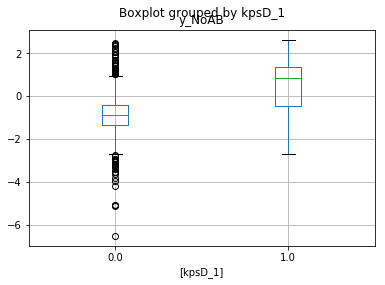

In [19]:
PATH="/Users/moradigd/Documents/Prediction/"

response='Metadata_median_NoAB.txt'
reponse_dataframe=pd.read_csv(os.path.join(PATH, response), index_col=0, sep="\t")

import matplotlib.pyplot as plt
gene_presence_absence.join(reponse_dataframe,how='inner').loc[:,['y_NoAB','kpsD_1']].boxplot(by=['kpsD_1'])
plt.show()
#reponse_dataframe

### Deduplication and annotation 


The list of significant is further processed to attach functioinal groups and duplicate the entries with an identical gene presence-absence pattern. The following class process the final class. It takes the postfix of the drug class and returns the complete annotation file.  

In [8]:
class Hits:
    def __init__(self, PATH):
        self.PATH=PATH
        
    def create_pattern(self, pangenome_Rtab='gene_presence_absence.Rtab'):
        import pandas as pd
        import os
    
        pangenome_Rtab_file=pd.read_csv(os.path.join(self.PATH, pangenome_Rtab), index_col=0, sep='\t')
        pattern=pangenome_Rtab_file.apply(lambda x: str(x.tolist()), axis=1)
        pattern_id=pd.DataFrame(list(zip(pangenome_Rtab_file.index.tolist(),pattern)))
        pattern_id.columns=['Gene', 'Pattern']
        pattern_id=pattern_id.set_index('Gene')
    
        return pattern_id

    def define_importance(self, postfix, pattern=True):
        import pandas as pd
        import os
    
        postfix_importance='importance_xgr_'+postfix+'.txt'
        importance=pd.read_csv(os.path.join(self.PATH, postfix_importance),  sep='\t')
        importance['Pattern']=self.pattern_id.Pattern[importance.Gene].tolist()
        importance.drop('Gene', axis=1, inplace=True)
        self.pattern_id=self.pattern_id.reset_index()
        merged_pattern_importance = importance.merge(self.pattern_id, left_on=['Pattern'], right_on = ['Pattern'], how='left')
        merged_pattern_importance.drop(['Pattern'], axis=1, inplace=pattern)
        return merged_pattern_importance

    def attach_annotation(self, pangenome_csv='gene_presence_absence.csv'):
        pangenome_csv=pd.read_csv(os.path.join(self.PATH, pangenome_csv), index_col=0)
        pangenome_csv=pangenome_csv.iloc[:,0:13]
        return self.merged_pattern_importance.merge(pangenome_csv, left_on=['Gene'], right_on = ['Gene'], how='left')



In [23]:
PATH='/Users/moradigd/Documents/Prediction/Pan_genome'
Hits(PATH).create_pattern()

### Attach COG code and category 



In [1]:
gff_file="/Users/moradigd/Desktop/test_pan/assemblies/gffs/pan_genome/26329_1#286.velvet.gff"

In [157]:
def gene_attribute_finder(locus, gff_file):
    cog=open(gff_file)
    lines_cog=cog.readlines()
    indetified_line=lines_cog[np.where([locus in line for line in lines_cog])[0][0]]
    annotation_field=indetified_line.split("\t")[8]
    annotation_field_split=annotation_field.split(";")
    return(annotation_field_split)

In [158]:
def product_finder(*annotation_field_split):
    try:
        annotation_field_split_product=annotation_field_split[np.where(["product=" in line for line in annotation_field_split])[0][0]]
        return(re.sub("product=", "", annotation_field_split_product))
    except:
        return

In [159]:
def cog_finder(*annotation_field_split):
    try:
        COG_field=annotation_field_split[np.where(["COG" in line for line in annotation_field_split])[0][0]]
        COG_field_split=COG_field.split(",")
        COG_field_split_field=COG_field_split[np.where(["COG" in line for line in COG_field_split])[0][0]]
        return(re.sub("protein motif:Cdd:", "", COG_field_split_field))
    except:
        return

In [ ]:
def write_json(output_dict, PATH,file_name="cog_info.json"):
    import json
    import os
    file=os.path.join(PATH, file_name)
    with open(file, 'w', encoding='utf-8') as f:
        json.dump(output_dict,f,ensure_ascii=False, indent=4)

In [ ]:
json_file_path = "/Users/moradigd/Desktop/test_pan/assemblies/gffs/pan_genome/cog_info.json"

def read_json(file_name,PATH,data_frame=True):
    with open(json_file_path, 'r') as j:
        contents = json.loads(j.read())
        if data_frame==True:
            return(pd.DataFrame.from_dict(contents, orient='index'))
        else:
            return(contents)

In [ ]:
pan_genome_file="/Users/moradigd/Desktop/test_pan/assemblies/gffs/pan_genome/gene_presence_absence.csv"
pan_genome=pd.read_csv(pan_genome_file)

In [250]:
import numpy as np
import os
import pandas as pd
import re
from time import sleep
import sys

PATH="/Users/moradigd/Desktop/test_pan/assemblies/gffs/pan_genome"
output={}
for i in range(pan_genome.shape[0]):
    
    sys.stdout.write('\r')
    sys.stdout.write("[%-100s] %d%%" % ('='*int(100*i/pan_genome.shape[0]), 100))
    sys.stdout.flush()
    sleep(0.25)
    
    tmp=pan_genome.iloc[i,14:pan_genome.shape[1]].dropna().tolist()
    locus=tmp[0].split("\t")[0]
    gff_file=os.path.join(PATH,"_".join(locus.split("_")[0:2])+".velvet.gff")
    annotation_field_split=gene_attribute_finder(locus,gff_file)
    COG=cog_finder(*annotation_field_split)
    product=product_finder(*annotation_field_split)
    if COG!=None:
        output[pan_genome.iloc[i,0]]={'COG': COG, 'product': product}
    elif COG==None:
        output[pan_genome.iloc[i,0]]={'product': product}

write_json(output, PATH)

[                                                                                                    ] 100%

KeyboardInterrupt: 

In [239]:
write_json(output, PATH)